# Inpainting V1 demo: 減緩區塊重複被劃分計算 - DEMO

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from scipy import ndimage
from tqdm import tqdm

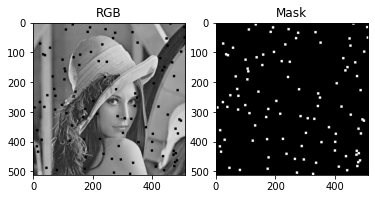

In [2]:
origin_path = '../data/Lenna/gray_maskV2/lenna_gray.png'
image_path = '../data/Lenna/gray_maskV2/lenna_gray_defect.png'
mask_path = '../data/Lenna/gray_maskV2/lenna_gray_mask.png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.THRESH_BINARY)
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
mask//=255

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax1.title.set_text("RGB")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask, cmap='gray')
ax2.title.set_text("Mask")
plt.show()

In [3]:
height, width = image.shape[:2]
patch_size = (5, 5)

confidence = (1-mask).astype("float32")
data = np.zeros(shape=(height, width))

working_image = np.copy(image)
working_mask = np.copy(mask)

DEBUG = True

[DEBUG] front:  512 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[DEMO] front_position:  5878 [[  0 456]
 [  0 457]
 [  0 458]
 ...
 [511 321]
 [511 328]
 [511 329]]


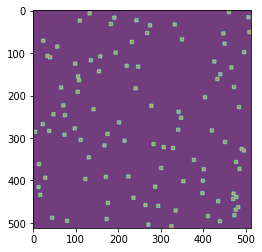

In [4]:
def _get_front():
    _front = (scipy.ndimage.laplace(working_mask)>0).astype(np.uint8)
    # _front = (scipy.ndimage.laplace(working_mask)>0).astype(np.uint8)

    ## CHECK
    if DEBUG:
        plt.imshow(working_mask, alpha=0.6)
        plt.imshow((_front == 1)*255, alpha=0.4)
    
    return _front

front = _get_front()
# plt.imshow(front)
if DEBUG:
    print("[DEBUG] front: ", len(front), front)

front_positions = np.argwhere(front == 1) ## [y, x] or [y, x, z]
print("[DEMO] front_position: ", len(front_positions), front_positions)

In [5]:
def _patch_data(source, patch):
    try:
        return source[
            patch[0][0]:patch[0][1]+1,
            patch[1][0]:patch[1][1]+1
        ]
    except: 
        print("[ERROR] _patch_data: patch", patch[0][0], "+", patch[0][1]+1, ",", patch[1][0], "+", patch[1][1]+1)

def _patch_shape(patch):
    return 1+patch[0][1]-patch[0][0], 1+patch[1][1]-patch[1][0]
    
def _get_patch(point, showPatch = False, padding = 0):
    patch = [
        [## Y
            max(0, point[0]-(patch_size[0]-1)//2),
            min(point[0]+(patch_size[0]-1)//2, height-1)
        ],
        [## X
            max(0, point[1]-(patch_size[1]-1)//2),
            min(point[1]+(patch_size[1]-1)//2, width-1)
        ]
    ]

    patch[0][0]-=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][1] == height-1 else 0
    patch[0][1]+=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][0] == 0 else 0
    patch[1][0]-=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][1] == width-1 else 0
    patch[1][1]+=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][0] == 0 else 0
    
    if showPatch:
        show_patch = [
            [## Y
                max(0, point[0]-(patch_size[0]-1)//2-padding),
                min(point[0]+(patch_size[0]-1)//2+padding, height-1)
            ],
            [## X
                max(0, point[1]-(patch_size[1]-1)//2-padding),
                min(point[1]+(patch_size[1]-1)//2+padding, width-1)
            ]
        ]
        print("[MESSAGE] _get_patch, point: ", point)
        print("patch[{}:{}, {}:{}]".format(patch[0][0], patch[0][1], patch[1][0], patch[1][1]))
        print("show_patch[{}:{}, {}:{}]".format(show_patch[0][0], show_patch[0][1], show_patch[1][0], show_patch[1][1]))
        patch_fronts = [
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0])
        ]
        print("patch_fronts", patch_fronts)
        plt.imshow(_patch_data(image, show_patch), alpha=1)
        plt.imshow(_patch_data(front, show_patch), alpha=0.4)
        plt.plot([p[1] for p in patch_fronts], [p[0] for p in patch_fronts], "-r")
        plt.plot(
            point[0]-show_patch[0][0], point[1]-show_patch[1][0],
            marker='.', 
            markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0])), 
            color='b'
        )
        plt.show()
    return patch

[DEMO] _get_patch: 
[MESSAGE] _get_patch, point:  [  0 456]
patch[0:4, 454:458]
show_patch[0:2, 454:458]
patch_fronts [(0, 0), (0, 4), (2, 4), (2, 0), (0, 0)]


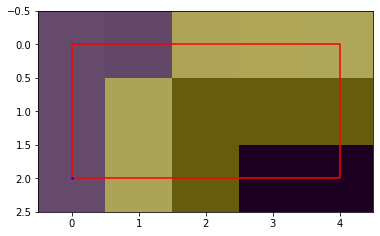

[MESSAGE] _get_patch, point:  [  0 456]
patch[0:4, 454:458]
show_patch[0:4, 452:460]
patch_fronts [(0, 2), (0, 6), (4, 6), (4, 2), (0, 2)]


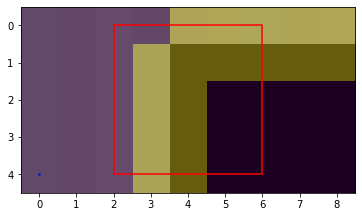

[DEMO] show_point_patch: 
[MESSAGE] show_point_patch


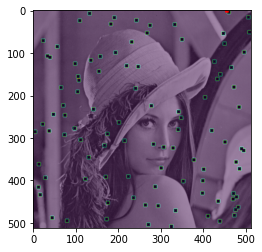

[DEMO] show_patch: 
[MESSAGE] show_patch
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[0:4, 454:458]
show_patch[0:6, 452:460]
patch_fronts [(0, 2), (0, 6), (6, 6), (6, 2), (0, 2)]


<AxesSubplot:title={'center':', padding=2'}>

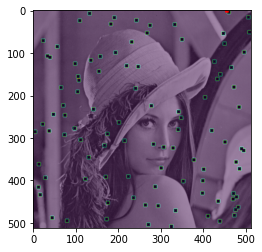

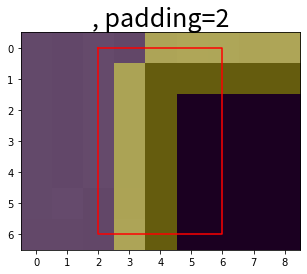

In [6]:
def show_point_patch(point, background=image, show_point=True):
    if DEBUG:
        print("[MESSAGE] show_point_patch")
    patch = _get_patch(point)
    # print(patch[0][0], patch[0][1])
    # print(patch[1][0], patch[1][1])
    plot_list = [
        (patch[0][0], patch[1][0]), 
        (patch[0][0], patch[1][1]), 
        (patch[0][1], patch[1][1]), 
        (patch[0][1], patch[1][0]), 
        (patch[0][0], patch[1][0])
    ]
    # print("plot", plot_list)
    plt.imshow(background)
    plt.imshow(front, alpha=0.4)
    plt.plot([p[1] for p in plot_list], [p[0] for p in plot_list], "-r")
    if show_point:
        plt.plot(point[1], point[0], marker='.', markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0]))/4, color='b')
    # plt.title(title)
    plt.show()

def _show_patch(source, patch, show_point=False, padding = 0, ax = None, ax_title = ""):
    if ax is None:
        fig, ax = plt.subplots()
    if DEBUG:
        print("[MESSAGE] show_patch")
    if padding > 0:
        show_patch = [
            [## Y
                max(0, patch[0][0]-padding),
                min(patch[0][1]+padding, height-1)
            ],
            [## X
                max(0, patch[1][0]-padding),
                min(patch[1][1]+padding, width-1)
            ]
        ]
        patch_fronts = [
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], show_patch[1][1]-patch[1][0]), 
            (show_patch[0][1]-patch[0][0], patch[1][0]-show_patch[1][0]), 
            (patch[0][0]-show_patch[0][0], patch[1][0]-show_patch[1][0])
        ]
        if DEBUG:
            print("[MESSAGE] _get_patch")
            print("patch[{}:{}, {}:{}]".format(patch[0][0], patch[0][1], patch[1][0], patch[1][1]))
            print("show_patch[{}:{}, {}:{}]".format(show_patch[0][0], show_patch[0][1], show_patch[1][0], show_patch[1][1]))
            print("patch_fronts", patch_fronts)
        ax.set_title(ax_title+", padding={}".format(padding), fontproperties="Noto Sans TC", fontsize=25)
        ax.imshow(_patch_data(source, show_patch), alpha=1)
        ax.imshow(_patch_data(front, show_patch), alpha=0.4)
        ax.plot([p[1] for p in patch_fronts], [p[0] for p in patch_fronts], "-r")
        if ax is None:
            plt.show()

        return ax
    else:
        ax.set_title(ax_title, fontproperties="Noto Sans TC", fontsize=25)
        ax.imshow(source)
        ax.imshow(front, alpha=0.4)
        plot_list = [(patch[0][0], patch[1][0]), (patch[0][0], patch[1][1]), (patch[0][1], patch[1][1]), (patch[0][1], patch[1][0]), (patch[0][0], patch[1][0])]
        ax.plot([p[1] for p in plot_list], [p[0] for p in plot_list], "-r")
        if show_point:
            ax.plot(
                (patch[1][1]+patch[1][0])/2, (patch[0][1]+patch[0][0])/2, 
                marker='.', 
                markersize=np.sqrt(np.sqrt(patch[0][1]-patch[0][0])*(patch[1][1]-patch[1][0])), 
                color='b'
            )
        if ax is None:
            plt.show()

        return ax


test_index = 0
# print(front_positions[0])
print("[DEMO] _get_patch: ")
_get_patch(front_positions[test_index], showPatch=DEBUG)
_get_patch(front_positions[test_index], showPatch=DEBUG, padding=2)
print("[DEMO] show_point_patch: ")
show_point_patch(front_positions[test_index], show_point = False)
print("[DEMO] show_patch: ")
_show_patch(image, _get_patch(front_positions[test_index]))
_show_patch(image, _get_patch(front_positions[test_index]), padding=2)

In [7]:
test_patch =  _get_patch(front_positions[0])
test_patch

[[0, 4], [454, 458]]

In [8]:
test_patch[0][1]-test_patch[0][0]

4

In [9]:
for p in front_positions:
    patch = _get_patch(p)
    if patch[0][1]-patch[0][0]!= patch_size[0]-1 or patch[1][1]-patch[1][0]!= patch_size[1]-1:
        print("[ERROR] patch: " , patch)
        _show_patch(working_mask, patch, padding=5)

[DEBUG] front:  512 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[DEMO] front_position:  5878 [[  0 456]
 [  0 457]
 [  0 458]
 ...
 [511 321]
 [511 328]
 [511 329]]


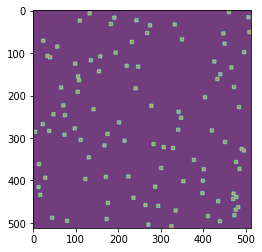

In [10]:
def _get_front():
    _front = (scipy.ndimage.laplace(working_mask)>0).astype(np.uint8)
    # _front = (scipy.ndimage.laplace(working_mask)>0).astype(np.uint8)

    ## CHECK
    if DEBUG:
        plt.imshow(working_mask, alpha=0.6)
        plt.imshow((_front == 1)*255, alpha=0.4)
    
    return _front

front = _get_front()
# plt.imshow(front)
if DEBUG:
    print("[DEBUG] front: ", len(front), front)
    
front_positions = np.argwhere(front == 1) ## [y, x] or [y, x, z]
print("[DEMO] front_position: ", len(front_positions), front_positions)

In [11]:
shape_list = np.zeros(shape=patch_size)

for pos in front_positions:
    shape = _patch_shape(_get_patch(pos))
    shape_list[shape[0]-1][shape[1]-1] += 1

print(shape_list)

[[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 5878.]]


[DEMO] _update_confidence: confidence[]


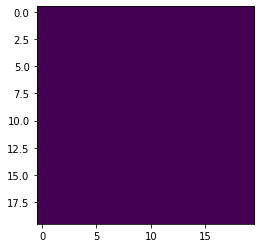

In [12]:
def _get_confidence(point):
    # patch = _get_patch(point, True)
    patch = _get_patch(point)
    patch_confidence = _patch_data(confidence, patch)
    # print(patch_confidence)
    # plt.imshow(patch_confidence, alpha=1)
    # print(patch_confidence.sum(), "/", patch_confidence.shape[0]*patch_confidence.shape[1])
    return patch_confidence.sum() / (patch_confidence.shape[0]*patch_confidence.shape[1])

def _update_confidence(confidence):
    new_confidence = np.copy(confidence)
    for point in tqdm(front_positions):
        new_confidence[point[0], point[1]] = _get_confidence(point)
    confidence = new_confidence
    return confidence
    # ## DEBUG
    # _get_confidence(front_positions[50])

print("[DEMO] _update_confidence: confidence[]")
# confidence = _update_confidence(confidence)
if DEBUG:
    test = confidence[100:120, 100:120]
    plt.imshow(test)

(512, 512)


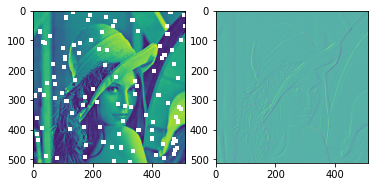

[DEMO] _update_data: data [[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]


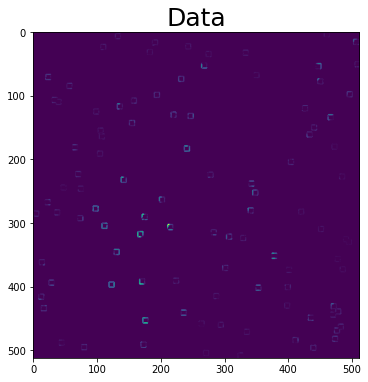

In [13]:
from skimage import io, color



# ax_normal = plt.subplot(1, 3, 1)
# ax_gradient = plt.subplot(1, 3, 2)
# ax_data = plt.subplot(1, 3, 3)

def _update_data(working_image, working_mask, front):
    normal = _calc_normal_matrix(working_mask)
    # ax_normal.imshow(normal)
    # ax_normal.title("normal")
    
    gradient = _calc_gradient_matrix(working_image, working_mask, front)
    # ax_gradient.imshow(gradient)
    # ax_gradient.title("gradient")
    
    normal_gradient = normal*gradient
    data = np.sqrt(normal_gradient[:, :, 0]**2 + normal_gradient[:, :, 1]**2) + 0.001
    # ax_data.imshow(data)
    # ax_data.title("data")
    return data
    
def _calc_normal_matrix(working_mask):
    x_kernal = np.array([
        [.25, 0, -.25],
        [.5, 0, -.5],
        [.25, 0, -.25],
    ])
    y_kernal = np.array([
        [-.25, -.5, -.25],
        [0, 0, 0],
        [.25, .5, .25],
    ])
    
    x_normal = scipy.ndimage.convolve(working_mask.astype('float64'), x_kernal)
    y_normal = scipy.ndimage.convolve(working_mask.astype('float64'), y_kernal)
    normal = np.dstack((x_normal, y_normal))
    
    height, width = normal.shape[:2]
    norm = np.sqrt(y_normal**2 + x_normal**2) \
        .reshape(height, width, 1) \
        .repeat(2, axis=2)
    norm[norm == 0] = 1
    unit_normal = normal/norm
    return unit_normal
    
def _calc_gradient_matrix(working_image, working_mask, front):
    height, width = working_image.shape[:2]    
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # _, gray_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    # gray_image//=255
    gray_image = color.rgb2gray(working_image)
    gray_image[working_mask == 1] = None
    gradient = np.nan_to_num(np.array(np.gradient(gray_image)))
    if DEBUG:
        print(gray_image.shape)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(gray_image)
        
        axs[1].imshow(gradient[0], alpha=0.5)
        axs[1].imshow(gradient[1], alpha=0.5)
        plt.show()
    
    gradient_val = np.sqrt(gradient[0]**2 + gradient[1]**2)
    max_gradient = np.zeros([height, width, 2])
    
    front_positions = np.argwhere(front == 1)
    for point in front_positions:
        patch = _get_patch(point)
        patch_y_gradient = _patch_data(gradient[0], patch)
        patch_x_gradient = _patch_data(gradient[1], patch)
        patch_gradient_val = _patch_data(gradient_val, patch)
        
        patch_max_pos = np.unravel_index(
            patch_gradient_val.argmax(),
            patch_gradient_val.shape
        )
        
        max_gradient[point[0], point[1], 0] = patch_y_gradient[patch_max_pos]
        max_gradient[point[0], point[1], 1] = patch_x_gradient[patch_max_pos]
    
    return max_gradient
# DEBUG = False
data = _update_data(working_image, working_mask, front)
print("[DEMO] _update_data: data", data)
fig = plt.figure(figsize=(6, 6))
plt.title('Data', fontsize=25)
plt.imshow(data)
plt.show()

100%|██████████| 5878/5878 [00:00<00:00, 71009.84it/s]


[DEBUG] confidence (512, 512) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(512, 512)


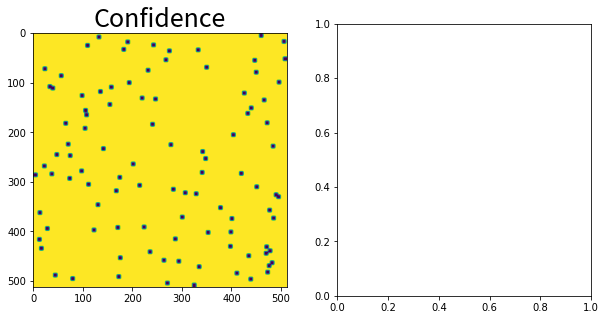

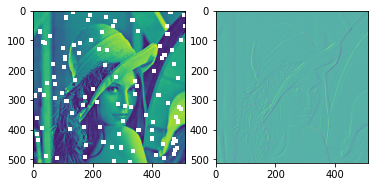

[DEBUG] data (512, 512) [[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]


In [14]:
fig = plt.figure(figsize=(10,5))

ax_confidence = fig.add_subplot(1, 2, 1)
ax_data = fig.add_subplot(1, 2, 2)
# ax_priority = fig.add_subplot(1, 3, 3)

def _update_priority(working_image, working_mask, confidence, front, ax_confidence=None, ax_data=None):
    if ax_confidence is None:
        ax_confidence = plt.subplot(111)
    if ax_data is None:
        ax_data = plt.subplot(111)
    confidence = _update_confidence(confidence)
    if DEBUG:
        print("[DEBUG] confidence", confidence.shape, confidence)
    ax_confidence.imshow(confidence)
    ax_confidence.set_title("Confidence", fontproperties="Noto Sans TC", fontsize=25)
    data = _update_data(working_image, working_mask, front)
    if DEBUG:
        print("[DEBUG] data", data.shape, data)
    ax_data.imshow(data)
    ax_data.set_title("Data", fontproperties="Noto Sans TC", fontsize=25)
    priority = confidence*data*front
    return priority

priority = _update_priority(
    working_image, working_mask, confidence, front,
    ax_confidence=ax_confidence,
    ax_data=ax_data,
)
plt.show()

[DEMO] _find_highest_priority_pixel: target_pixel (302, 211)
[MESSAGE] show_point_patch


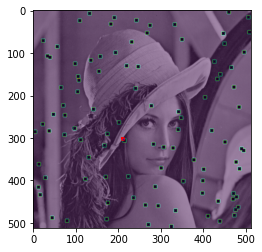

[MESSAGE] _get_patch, point:  (302, 211)
patch[300:304, 209:213]
show_patch[297:307, 206:216]
patch_fronts [(3, 3), (3, 7), (7, 7), (7, 3), (3, 3)]


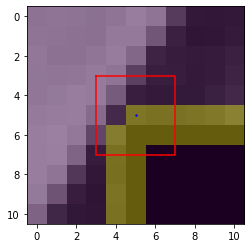

[[300, 304], [209, 213]]

In [15]:
def _find_highest_priority_pixel(priority):
    point = np.unravel_index(
        priority.argmax(),
        priority.shape
    )
    return point

target_pixel = _find_highest_priority_pixel(priority)
print("[DEMO] _find_highest_priority_pixel: target_pixel", target_pixel)
show_point_patch(target_pixel)
# _get_patch(target_pixel, True)
_get_patch(target_pixel, showPatch=DEBUG, padding = 3)
# _get_patch((target_pixel[1], target_pixel[0]), True)

In [16]:
## TODO: 理想情況：當patch_size都一致時，不需重新計算source_patchs，因此速度最快
## 替換作法1：排序計算target_pixel 從最小的patch_size開始進行替換，不過因替換順數改變，所以效果可能與原先的做法不同
## 延伸作法1：加入使用database儲存計算過的source_patchs，這樣就能夠還是以最優先權的target_pixel進行替換，且利用storage來除存減少記憶體使用

## 筆記
## 只有邊框的mask's patch size會可能不是設定的patch_size，這些塊的中心點應該要重新計算到patch's size與設定的相同(不過這也意味著 可能破壞掉原本正常的像素)
## 因為我們找的中心點都是在破壞的邊框上，所以該中心點應該重置讓他的patch大小正確

from skimage import io, color

## @staticmethod
def _to_rgb(image):
    height, width = image.shape
    return image.reshape(height, width, 1).repeat(3, axis=2)

# eligible patch list
def ELIG_patch_list(source, patch_list):
    eligible_patch_list = np.array([
        patch
        for patch in patch_list
        if _patch_data(source, patch).sum() == 0
    ], dtype=np.int64)
    return eligible_patch_list

def _find_source_patch(working_image, target_pixel):
    lab_image = color.rgb2lab(working_image)
    mask = 1-_patch_data(working_mask, target_patch)

def _patch_list(height, width, patch_height, patch_width, base_height=0, base_width=0):
    for y in range(base_height, base_height+height-patch_height+1):
        for x in range(base_width, base_width+width-patch_width+1):
            yield [y, y+patch_height-1], [x, x+patch_width-1]

lab_image = color.rgb2lab(working_image)

In [17]:
target_patch = _get_patch(target_pixel)

## test
### check大小與 normal source_patchs 一樣，不同無法計算
patch_height, patch_width = _patch_shape(target_patch)
mask = 1-_patch_data(working_mask, target_patch)
rgb_mask = _to_rgb(mask)

In [18]:
try:
    source_patchs
except NameError:
    source_patchs = ELIG_patch_list(working_mask, _patch_list(height, width, patch_height, patch_width))
    lab_image_source_patchs_data = [_patch_data(lab_image, patch) for patch in source_patchs]

In [19]:
type(target_patch), type(source_patchs)

(list, numpy.ndarray)

In [20]:
source_patchs[:][0][0]

array([0, 4], dtype=int64)

In [21]:
target_patch_data = _patch_data(lab_image, target_patch)*rgb_mask
squared_distance = ((target_patch_data - lab_image_source_patchs_data*rgb_mask)**2).sum(axis=(3, 2, 1))
euclidean_distance = np.sqrt(
    (target_patch[0][0] - source_patchs[:, 0, 0])**2 +
    (target_patch[1][0] - source_patchs[:, 1, 0])**2
)

In [23]:
print("[DEBUG] squared_distance", squared_distance.min())
print("[DEBUG] euclidean_distance", euclidean_distance.min())
diff = squared_distance + euclidean_distance
print("[DEBUG] diff[diff.argmin()]", diff.min())
mix_source_index = diff.argmin()
source_patch = source_patchs[diff.argmin()]
mix_source_index, source_patch

[DEBUG] squared_distance 174.49272256953066
[DEBUG] euclidean_distance 2.0
[DEBUG] diff[diff.argmin()] 178.09827384499465


(143388,
 array([[297, 301],
        [211, 215]], dtype=int64))

In [24]:
## 要準備更新的起始點
target_patch = _get_patch(target_pixel)
target_patch 

[[300, 304], [209, 213]]

[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[300:304, 209:213]
show_patch[295:309, 204:218]
patch_fronts [(5, 5), (5, 9), (9, 9), (9, 5), (5, 5)]
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[297:301, 211:215]
show_patch[292:306, 206:220]
patch_fronts [(5, 5), (5, 9), (9, 9), (9, 5), (5, 5)]


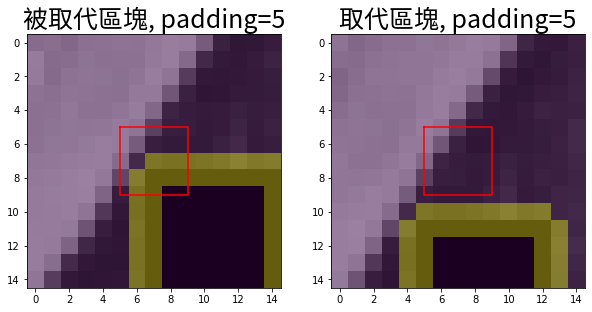

In [25]:
## 這邊有點問題 區塊應該吃得剛剛好 但目前結果差了一點(很有問題)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
_show_patch(working_image, target_patch, ax=axs[0], padding=5, ax_title="被取代區塊")
_show_patch(working_image, source_patch, ax=axs[1], padding=5, ax_title="取代區塊")
plt.show()

## TODO: 更新圖片。將要替換的target替換後，將eligible的patch在inpainted後的working_image更新部分，新增進到source_patchs 以及 lab_image_source_patchs_data
### 做法1：取範圍最小到最大的座標，並計算影響範圍並加入倒source_patchs，然後移除重複
### 做法2：找出範圍邊框，並計算影響範圍並加入倒source_patchs，然後移除重複
### 作法3：劃分範圍成幾個區塊(最理想只有一個)，然後逐一執行作法2

In [70]:
## 1為準備要被更新的部分
print("[target_patch[0][0], target_patch[1][0]]: ", target_patch[0][0], target_patch[1][0])
# target_patch_shape = _patch_shape(target_patch)
# test_pd = np.zeros(shape=(target_patch_shape[0]+2, target_patch_shape[1]+2))
# test_pd[1:-1, 1:-1] = _patch_data(working_mask, target_patch)

associate_pos = np.argwhere(
    _patch_data(working_mask, target_patch) == 1
)

[target_patch[0][0], target_patch[1][0]]:  28 0


In [71]:
min_patch_pos = min(associate_pos[:, 0])+target_patch[0][0], min(associate_pos[:, 1])+target_patch[1][0]
min_patch_pos

(28, 0)

In [76]:
## TODO: 如果目前的算法有問題，理論上來說 應該要上min()
# associate_patch = [
#     [max(min_patch_pos[0]-patch_size[0]+1, 0), min(min_patch_pos[0]+(max(associate_pos[:, 0])-min(associate_pos[:, 0])), height-1)],
#     [max(min_patch_pos[1]-patch_size[1]+1, 0), min(min_patch_pos[1]+(max(associate_pos[:, 1])-min(associate_pos[:, 1])), width-1)]
# ]
associate_patch = [
    [max(min_patch_pos[0]-patch_size[0]+1, 0), min_patch_pos[0]+(max(associate_pos[:, 0])-min(associate_pos[:, 0]))],
    [max(min_patch_pos[1]-patch_size[1]+1, 0), min_patch_pos[1]+(max(associate_pos[:, 1])-min(associate_pos[:, 1]))]
]
associate_patch

[[24, 31], [0, 3]]

[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[28:36, 0:8]
show_patch[23:41, 0:13]
patch_fronts [(5, 0), (5, 13), (13, 13), (13, 0), (5, 0)]
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[24:31, 0:3]
show_patch[19:36, 0:8]
patch_fronts [(5, 0), (5, 8), (12, 8), (12, 0), (5, 0)]


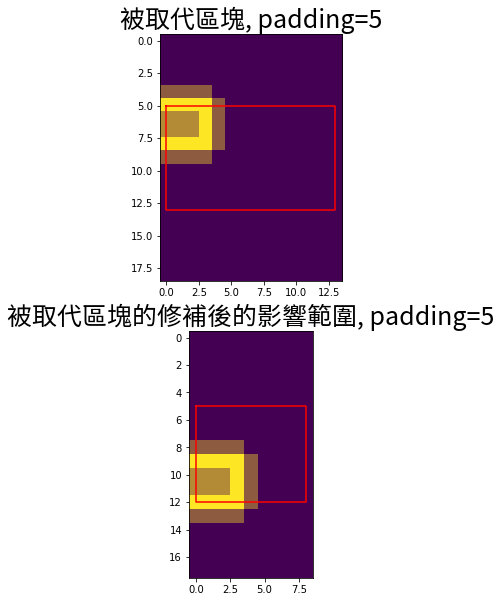

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

_show_patch(working_mask, target_patch, ax=axs[0], padding=5, ax_title="被取代區塊")

_show_patch(
    working_mask, 
    associate_patch, 
    ax=axs[1], 
    padding=5,
    ax_title="被取代區塊的修補後的影響範圍"
)

plt.show()

[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 410:414]
show_patch[492:511, 395:429]
patch_fronts [(15, 15), (15, 19), (4, 19), (4, 15), (15, 15)]
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 410:414]
show_patch[492:511, 395:429]
patch_fronts [(15, 15), (15, 19), (4, 19), (4, 15), (15, 15)]


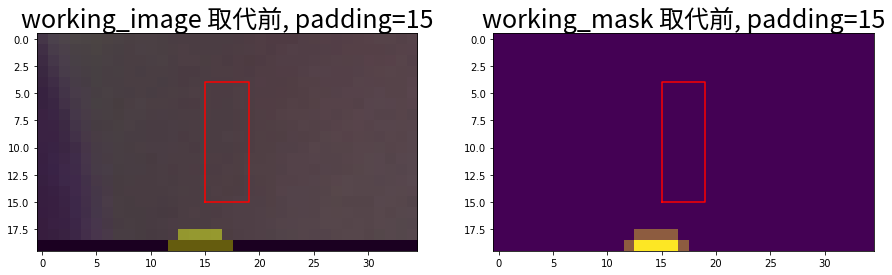

[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 410:414]
show_patch[492:511, 395:429]
patch_fronts [(15, 15), (15, 19), (4, 19), (4, 15), (15, 15)]
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 410:414]
show_patch[492:511, 395:429]
patch_fronts [(15, 15), (15, 19), (4, 19), (4, 15), (15, 15)]


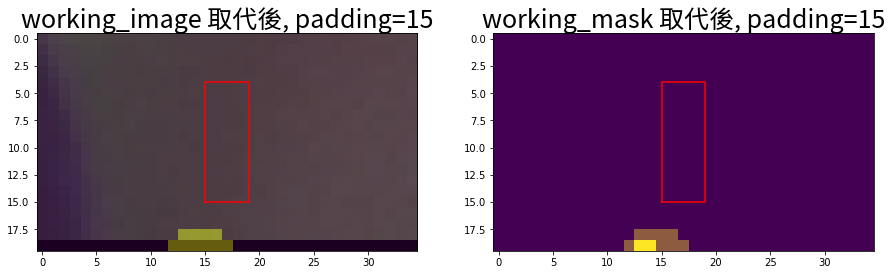

In [65]:
# 替換 區塊

def _copy_to_patch(dest, dest_patch, data):
    dest[
        dest_patch[0][0]:dest_patch[0][1]+1,
        dest_patch[1][0]:dest_patch[1][1]+1
    ] = data


pixels_positions = np.argwhere(
    _patch_data(working_mask, target_patch) == 1
) + [target_patch[0][0], target_patch[1][0]]
patch_confidences = confidence[target_pixel[0], target_pixel[1]]
for point in pixels_positions:
    confidence[point[0], point[1]] = patch_confidences
mask = _patch_data(working_mask, target_patch)
rgb_mask = _to_rgb(mask)
source_data = _patch_data(working_image, source_patch)
target_data = _patch_data(working_image, target_patch)
new_data = source_data*rgb_mask + target_data*(1-rgb_mask)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
_show_patch(working_image, target_patch, show_point=False, padding = 15, ax=axs[0], ax_title="working_image 取代前")
_show_patch(working_mask, target_patch, show_point=False, padding = 15, ax=axs[1], ax_title="working_mask 取代前")
plt.show()

_copy_to_patch(
    working_image,
    target_patch,
    new_data
)
_copy_to_patch(
    working_mask,
    target_patch,
    0
)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
_show_patch(working_image, target_patch, show_point=False, padding = 15, ax=axs[0], ax_title="working_image 取代後")
_show_patch(working_mask, target_patch, show_point=False, padding = 15, ax=axs[1], ax_title="working_mask 取代後")
plt.show()

[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 410:414]
show_patch[502:511, 405:419]
patch_fronts [(5, 5), (5, 9), (4, 9), (4, 5), (5, 5)]
[MESSAGE] show_patch
[MESSAGE] _get_patch
patch[507:511, 406:411]
show_patch[502:511, 401:416]
patch_fronts [(5, 5), (5, 10), (4, 10), (4, 5), (5, 5)]


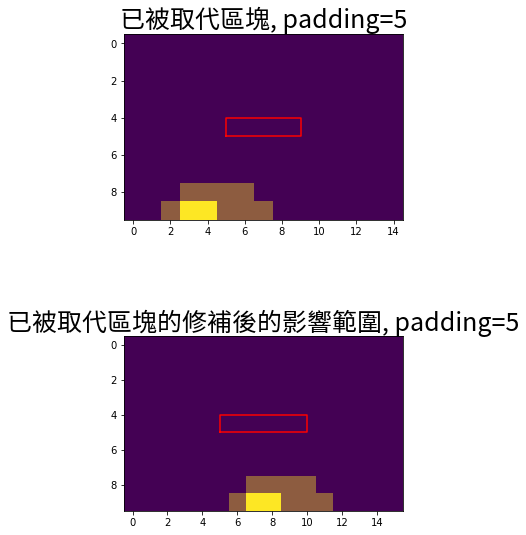

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

_show_patch(working_mask, target_patch, ax=axs[0], padding=5, ax_title="已被取代區塊")

_show_patch(
    working_mask, 
    associate_patch, 
    ax=axs[1], 
    padding=5,
    ax_title="已被取代區塊的修補後的影響範圍"
)

plt.show()

In [67]:
## TODO: 解決重複的區塊(垃圾)問題
## 參考資料: https://www.cnpython.com/qa/228231

def update_elig(working_mask, lab_image, associate_patch, patchs, patchs_data):
    elig = np.array(ELIG_patch_list(
        working_mask,
        _patch_list(
            associate_patch[0][1] - associate_patch[0][0], 
            associate_patch[1][1] - associate_patch[1][0], 
            patch_size[0], patch_size[1], 
            base_height=associate_patch[0][0]+1, 
            base_width=associate_patch[1][0]+1
        )
    ))

    for patch in elig:
        print(patch)
        _show_patch(working_mask, patch, padding=5)

    if elig.size > 0:
        print(elig.size)
        ## 會有問題 unique兩個陣列出來的size不一定相同
        # source_patchs = np.unique(source_patchs + elig)
        # lab_image_source_patchs_data = np.unique(lab_image_source_patchs_data + [_patch_data(lab_image, patch) for patch in elig])
        patchs = np.concatenate([elig, patchs])
        # print("[DEBUG] patchs", patchs)
        patchs_data = np.concatenate([[_patch_data(lab_image, patch) for patch in elig], patchs_data])
    return patchs, patchs_data

source_patchs, lab_image_source_patchs_data = update_elig(working_mask, lab_image, associate_patch, source_patchs, lab_image_source_patchs_data)

In [68]:
test = np.array(source_patchs)
test.shape, test

((369442, 2, 2),
 array([[[  0,   4],
         [  0,   4]],
 
        [[  0,   4],
         [  1,   5]],
 
        [[  0,   4],
         [  2,   6]],
 
        ...,
 
        [[507, 511],
         [761, 765]],
 
        [[507, 511],
         [762, 766]],
 
        [[507, 511],
         [763, 767]]], dtype=int64))

In [31]:
len(source_patchs), source_patchs

(228851,
 array([[[254, 262],
         [153, 161]],
 
        [[254, 262],
         [154, 162]],
 
        [[254, 262],
         [155, 163]],
 
        ...,
 
        [[503, 511],
         [501, 509]],
 
        [[503, 511],
         [502, 510]],
 
        [[503, 511],
         [503, 511]]], dtype=int64))